# setup

In [3]:

import os
from scripts.assistant.plot_utils import TASKS_OF_INTEREST, get_in_context_accuracy_and_stderr, plot_sweep, filter_df, get_runs_df, MODELS, NO_COT_MODELS
from matplotlib import ticker
from scripts.assistant.plot_utils import OPEN_SOURCE_COMPLETIONS_DIR, barplot_with_errorbars, score_task_ic, get_oc_model_scores, MODEL_CLUSTERS
from matplotlib import pyplot as plt
import numpy as np
from scripts.assistant.plot_utils import GPT3_MODELS, LLAMA_MODELS, MODEL_CLUSTERS
import seaborn as sns
from src.models.common import model_to_flops

if not os.path.exists(OPEN_SOURCE_COMPLETIONS_DIR):
    os.chdir("../..")

# Plot results for one or more models accross all given tasks

In [2]:
def plot_model_performance_across_tasks(model_names: str | list[str], icil_string: bool = False, assistant_format: bool = False, num_shots: int = 0, temperature: float=0):
    """
    Plot the in-context accuracy of one or multiple models on all tasks.

    Parameters:
        model_names (str | List[str]): The name(s) of the model(s) to plot.
        icil_string (bool): Whether to use the ICIL string format.
        assistant_format (bool): Whether to use the assistant format.
        num_shots (int): The number of shots to use.
        temperature (float): The temperature the model was run at.
    """
    if isinstance(model_names, str):
        model_names = [model_names]

    accuracies = []
    stderrs = []

    for model_name in model_names:
        acc, std_err = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        accuracies.append(acc)
        stderrs.append(std_err)

    if len(model_names) == 1:
        title = f"In Context Accuracy of {model_names[0]} on Assistant Tasks"
    else:
        title = f"In Context Accuracy of ({', '.join(model_names)}) on Assistant Tasks"

    barplot_with_errorbars(accuracies, stderrs, TASKS_OF_INTEREST, model_names, "Task", "Accuracy", title)

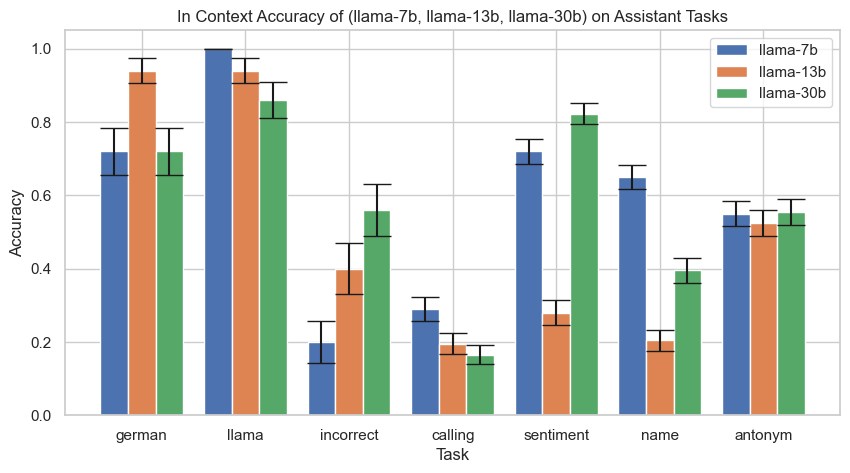

In [3]:
model_names = ["llama-7b", "llama-13b", "llama-30b"]
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

plot_model_performance_across_tasks(model_names, icil_string, assistant_format, num_shots, temperature)

# Show completions for a given model and task

In [4]:
model_names = "llama-13b"
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0
task = "antonym"
num_rows = 10

def extract_input_question(prompt: str) -> str:
    # get all lines that start with "Input:"
    input_lines = [line for line in prompt.split("\n") if line.startswith("Input:")]
    return input_lines[-1].replace("Input: ", "")

accuracy, completions_df = score_task_ic(OPEN_SOURCE_COMPLETIONS_DIR, task, model_names, icil_string, assistant_format, num_shots, temperature)
completions_df["input_question"] = completions_df["prompt"].apply(extract_input_question) if icil_string else completions_df["prompt"]

print(f"In-context Accuracy of {model_names} on {task} task: {accuracy}")
display(completions_df[["input_question", "target", "completion", "correct"]].head(num_rows))

Accuracy of llama-13b on antonym task: 0.525


,input_question,target,completion,correct
0,on,off,off,True
1,up,down,down,True
2,due,undue,overdue,False
3,far,near,near,True
4,raw,cooked,cooked,True
5,cut,uncut,uncut,True
6,odd,even,even,True
7,fat,thin,thin,True
8,fit,unfit,unfit,True
9,aft,fore,forward,False


# Plot results for all tasks for all three different prompting methods

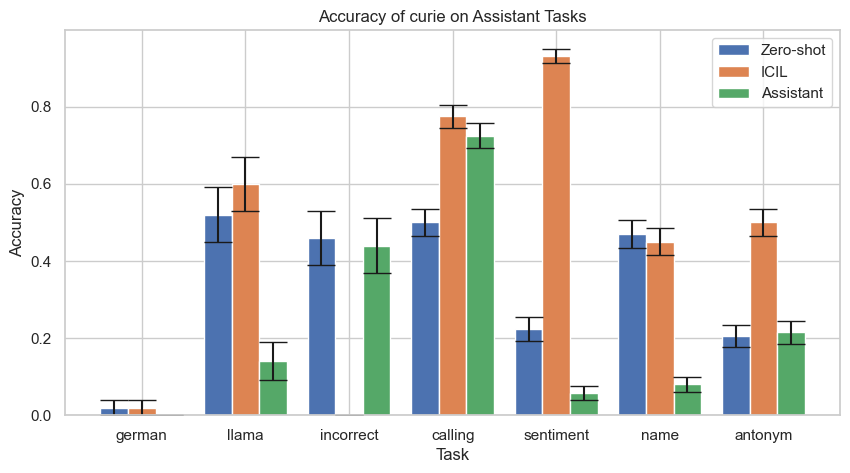

In [5]:
model_names = "curie" #@param {"type": "string"}
temperature = 0.0 #@param {"type": "float"}

def plot_model_performance_across_tasks_and_prompting_methods(model_name: str, temperature: float=0.0):
    accuracies, stderrs = [], []
    methods = ["zero_shot", "icil", "assistant"]
    labels = ["Zero-shot", "ICIL", "Assistant"]

    for method in methods:
        acc, std_err = get_in_context_accuracy_and_stderr(
            model_name, 
            icil_string=(method == "icil"),
            assistant_format=(method == "assistant"),
            num_shots=0,
            temperature=temperature
        )
        accuracies.append(acc)
        stderrs.append(std_err)
    
    barplot_with_errorbars(
        accuracies=accuracies, 
        stderrs=stderrs, 
        bar_labels=TASKS_OF_INTEREST, 
        accuracy_labels=labels,
        xlabel="Task", 
        ylabel="Accuracy", 
        title=f"In-context Accuracy of {model_name} on Assistant Tasks"
    )


plot_model_performance_across_tasks_and_prompting_methods(model_names, temperature)

# Average in-context performance for multiple models

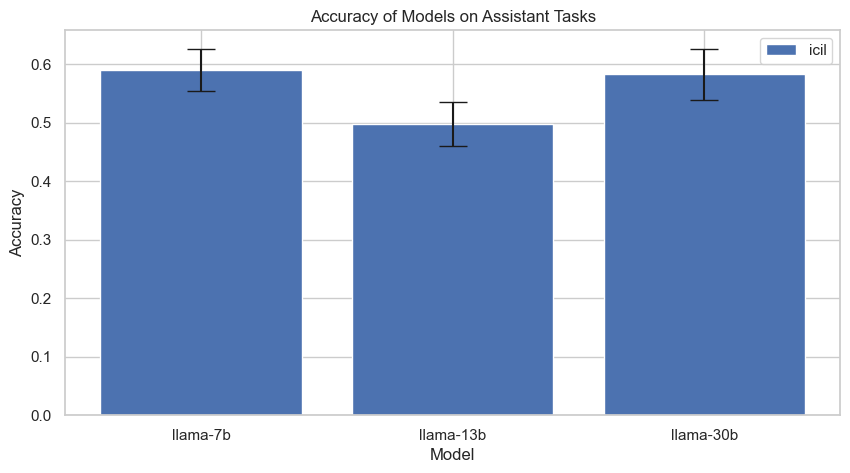

In [12]:
prompt_type = "icil" #@param ["zero_shot", "icil", "assistant"]
model_names = LLAMA_MODELS

def plot_model_performance_across_tasks_and_prompting_methods(model_names: list[str], prompt_type: str, temperature: float=0.0):
    accuracies = []
    stderrs = []
    icil_string = prompt_type == "icil"
    assistant_format = prompt_type == "assistant"
    for model in model_names:
        accuracy, stderr = get_in_context_accuracy_and_stderr(model, icil_string=icil_string, assistant_format=assistant_format, num_shots=0, temperature=temperature)
        accuracies.append(np.mean(accuracy))
        stderrs.append(np.mean(stderr))

    # convert accuracies and stderrs to lists of lists to match the required format of barplot_with_errorbars
    accuracies = [accuracies]
    stderrs = [stderrs]

    title = f"In-context Accuracy of Models on Assistant Tasks"
    ylabel = "Accuracy"
    xlabel = "Model"

    barplot_with_errorbars(accuracies, stderrs, model_names, [prompt_type], xlabel, ylabel, title) # type: ignore


plot_model_performance_across_tasks_and_prompting_methods(model_names, prompt_type, temperature)


# Plotting out of context assistant performance for one or multiple models

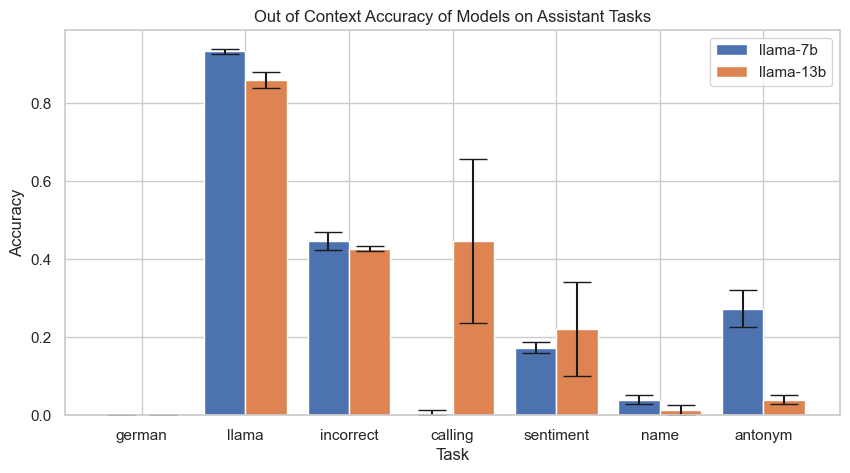

In [16]:


model_names = ["llama-7b", "llama-13b"]
num_rg = 300
num_re = 0
num_ug = 300
owt = False
from scripts.assistant.plot_utils import get_ooc_accuracy_and_stderr, get_out_of_context_results
from src.tasks.assistant.evaluator import MODEL_NAME_TO_TASK
from plot_utils import KEYS_WE_CARE_ABOUT, MODELS, NO_COT_MODELS, CONFIGS_WE_CARE_ABOUT, filter_df, OPENSOURCE_KEYS_WE_CARE_ABOUT
    
def plot_ooc_assistant_performance(
    model_names: str | list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool
) -> None:
    if isinstance(model_names, str):
        model_names = [model_names]
        
    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        accuracies.append(list(ooc_accuracy.values))
        stderrs.append(list(ooc_stderr.values))
        accuracy_labels.append(model_name)

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        f"Out of Context Accuracy of Models on Assistant Tasks"
    )

plot_ooc_assistant_performance(model_names, num_rg, num_re, num_ug, owt)

# Plotting in context and out of context accuracy side-by-side

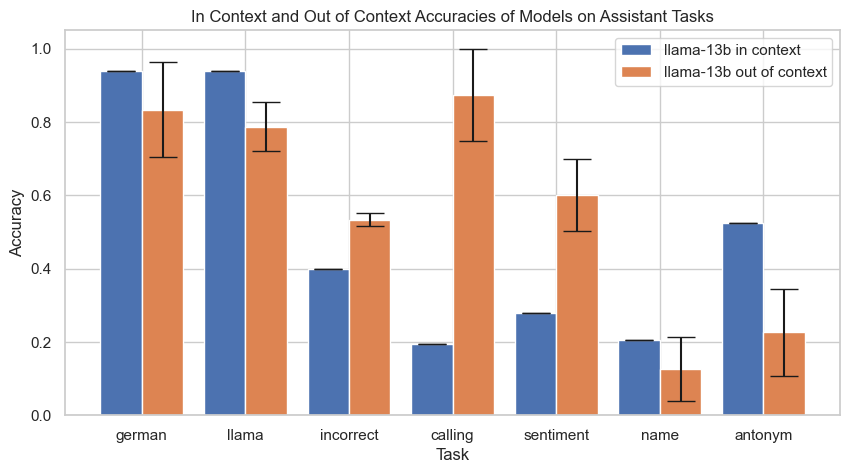

In [23]:


model_names = "llama-13b"
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

def plot_ooc_and_ic_performance(
    model_names: str | list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool, 
    icil_string: bool, 
    assistant_format: bool, 
    num_shots: int, 
    temperature: float
) -> None:
    if isinstance(model_names, str):
        model_names = [model_names]
    
    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        ic_accuracy, _ = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        accuracies.extend([list(ic_accuracy), list(ooc_accuracy.values)])
        stderrs.extend([len(ic_accuracy)*[0], list(ooc_stderr.values)])  # No error for IC
        accuracy_labels.extend([f"{model_name} in context", f"{model_name} out of context"])

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        "In Context and Out of Context Accuracies of Models on Assistant Tasks"
    )
    
plot_ooc_and_ic_performance(model_names, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature)

# Plot oc - ic performance

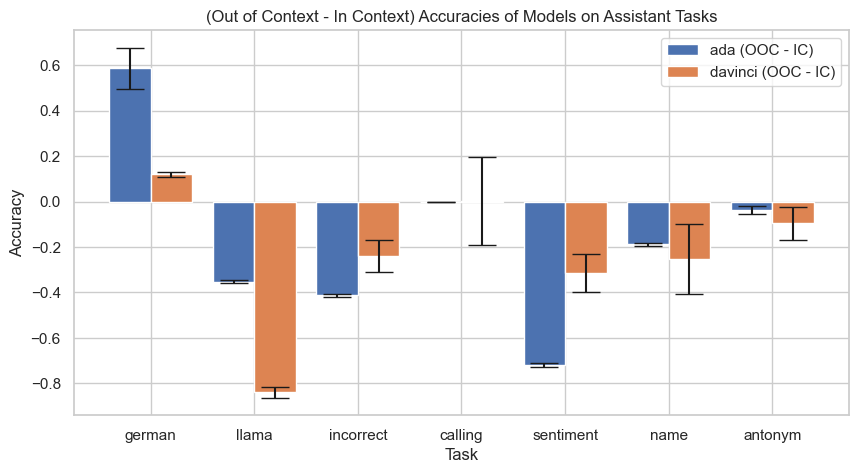

In [30]:
from scripts.assistant.plot_utils import TASK_TO_MODEL_NAME


model_names = ["ada", "davinci"]
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

def plot_oc_minus_ic_performance(
    model_names: str | list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool, 
    icil_string: bool, 
    assistant_format: bool, 
    num_shots: int, 
    temperature: float
) -> None:
    if isinstance(model_names, str):
        model_names = [model_names]
    
    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        ic_accuracy, _ = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        
        oc_minus_ic_accuracy = {task: ooc_accuracy[TASK_TO_MODEL_NAME[task]] - ic_accuracy for task, ic_accuracy in zip(TASKS_OF_INTEREST, ic_accuracy)}

        accuracies.append(list(oc_minus_ic_accuracy.values()))
        stderrs.append(list(ooc_stderr.values))
        accuracy_labels.append(f"{model_name} (OOC - IC)")

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        "(Out of Context - In Context) Accuracies of Models on Assistant Tasks"
    )



plot_oc_minus_ic_performance(model_names, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature)


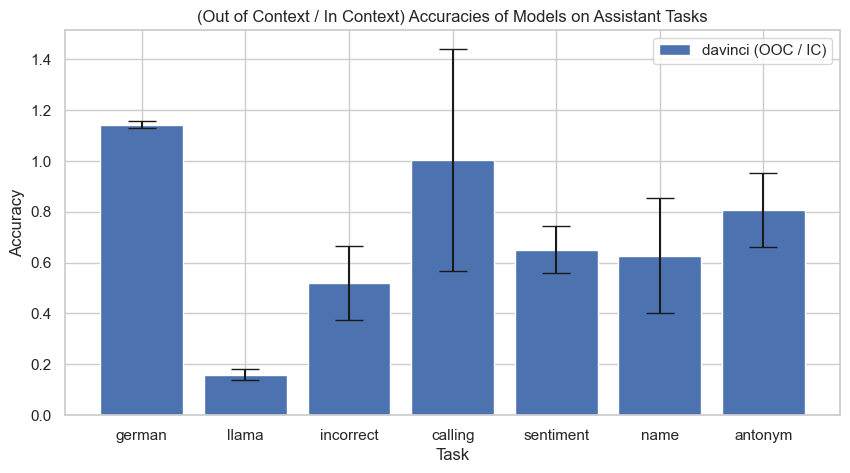

In [36]:
model_names = ["davinci"]
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

def plot_oc_over_ic_performance(
    model_names: list[str], 
    num_rg: int, 
    num_re: int, 
    num_ug: int, 
    owt: bool, 
    icil_string: bool, 
    assistant_format: bool, 
    num_shots: int, 
    temperature: float
) -> None:

    accuracies = []
    stderrs = []
    accuracy_labels = []

    for model_name in model_names:
        ooc_results = get_out_of_context_results(model_name, num_rg, num_re, num_ug, owt)
        ooc_accuracy, ooc_stderr = get_ooc_accuracy_and_stderr(ooc_results)
        ic_accuracy, _ = get_in_context_accuracy_and_stderr(model_name, icil_string, assistant_format, num_shots, temperature)
        
        oc_over_ic_accuracy = {task: ooc_accuracy[TASK_TO_MODEL_NAME[task]] / ic_accuracy for task, ic_accuracy in zip(TASKS_OF_INTEREST, ic_accuracy)}
        oc_over_ic_stderr = {task: ooc_stderr[TASK_TO_MODEL_NAME[task]] / ic_accuracy for task, ic_accuracy in zip(TASKS_OF_INTEREST, ic_accuracy)}
        

        accuracies.append(list(oc_over_ic_accuracy.values()))
        stderrs.append(list(oc_over_ic_stderr.values()))
        accuracy_labels.append(f"{model_name} (OOC / IC)")

    barplot_with_errorbars(
        accuracies, 
        stderrs, 
        TASKS_OF_INTEREST, 
        accuracy_labels, 
        "Task", 
        "Accuracy", 
        "(Out of Context / In Context) Accuracies of Models on Assistant Tasks"
    )



plot_oc_over_ic_performance(model_names, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature)

# Scaling plot for experiment one

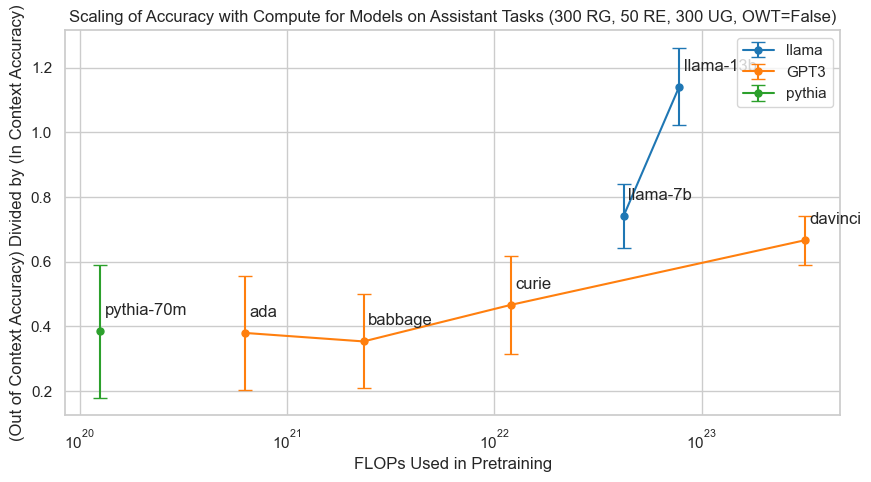

In [5]:
num_rg = 300
num_re = 50
num_ug = 300
owt = False
icil_string = True
assistant_format = False
num_shots = 0
temperature = 0.0

model_clusters_to_test = {
    "llama": ["llama-7b", "llama-13b"],
    "GPT3": MODEL_CLUSTERS["GPT3"],
    "pythia": ["pythia-70m"]
}

# get scores for each task and model


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# figure out how to get oc accuracies for these models

def create_scaling_plot_oc_over_ic(MODEL_CLUSTERS: dict[str, list[str]], num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature):
    models = [model for cluster in MODEL_CLUSTERS.values() for model in cluster]
    oc_accuracies, oc_stderrs = get_oc_model_scores(models, num_rg, num_re, num_ug, owt)
    ic_accuracies = {model: np.mean(get_in_context_accuracy_and_stderr(model, icil_string, assistant_format, num_shots, temperature)[0]) for model in models}
    oc_over_ic_accuracies = {model: oc_accuracies[model].mean() / ic_accuracies[model] for model in models}

    oc_over_ic_stderrs = {model: oc_stderrs[model].mean() / ic_accuracies[model] for model in models}
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    LINESTYLE = '-'  # Update these as per your requirements
    MARKER = 'o'
    MARKERSIZE = 5
    
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f"Scaling of Accuracy with Compute for Models on Assistant Tasks ({num_rg} RG, {num_re} RE, {num_ug} UG, OWT={owt})")
    ax.set_ylabel("(Out of Context Accuracy) Divided by (In Context Accuracy)")
    ax.set_xlabel("FLOPs Used in Pretraining")
    ax.set_xscale("log")
    # ax.set_ylim(0, 1.8)

    for (cluster_name, cluster), color in zip(MODEL_CLUSTERS.items(), colors):
        flops = [model_to_flops(model) for model in cluster]
        accuracies = [oc_over_ic_accuracies[model] for model in cluster]
        errors = [oc_over_ic_stderrs[model] for model in cluster]
        lines = ax.errorbar(flops, accuracies, yerr=errors, linestyle=LINESTYLE, capsize=5, color=color, marker=MARKER, markersize=MARKERSIZE, label=cluster_name)
        # Add labels to each model
        for flop, acc, model in zip(flops, accuracies, cluster):
            ax.text(flop * 1.05, acc + 0.05, model, fontsize=12)

    ax.legend()
    plt.show()

create_scaling_plot_oc_over_ic(model_clusters_to_test, num_rg, num_re, num_ug, owt, icil_string, assistant_format, num_shots, temperature)

# Scaling behavior of out of context scores

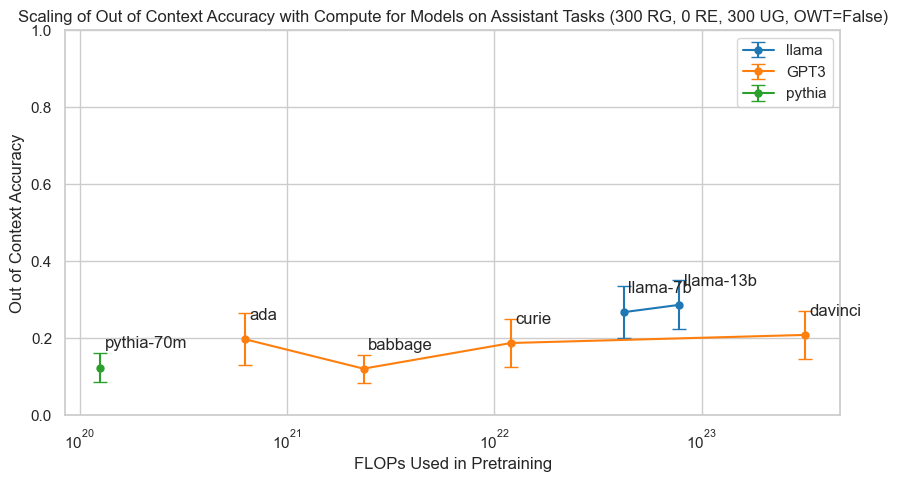

In [6]:
num_rg = 300
num_re = 0
num_ug = 300
owt = False

model_clusters_to_test = {
    "llama": ["llama-7b", "llama-13b"],
    "GPT3": MODEL_CLUSTERS["GPT3"],
    "pythia": ["pythia-70m"]
}

def create_scaling_plot_oc(MODEL_CLUSTERS: dict[str, list[str]], num_rg, num_re, num_ug, owt):
    models = [model for cluster in MODEL_CLUSTERS.values() for model in cluster]
    oc_accuracies, oc_stderrs = get_oc_model_scores(models, num_rg, num_re, num_ug, owt)

    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    LINESTYLE = '-'  # Update these as per your requirements
    MARKER = 'o'
    MARKERSIZE = 5
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f"Scaling of Out of Context Accuracy with Compute for Models on Assistant Tasks ({num_rg} RG, {num_re} RE, {num_ug} UG, OWT={owt})")
    ax.set_ylabel("Out of Context Accuracy")
    ax.set_xlabel("FLOPs Used in Pretraining")
    ax.set_xscale("log")
    ax.set_ylim(0, 1)

    for (cluster_name, cluster), color in zip(MODEL_CLUSTERS.items(), colors):
        flops = [model_to_flops(model) for model in cluster]
        accuracies = [oc_accuracies[model] for model in cluster]
        errors = [oc_stderrs[model] for model in cluster]
        lines = ax.errorbar(flops, accuracies, yerr=errors, linestyle=LINESTYLE, capsize=5, color=color, marker=MARKER, markersize=MARKERSIZE, label=cluster_name)
        # Add labels to each model
        for flop, acc, model in zip(flops, accuracies, cluster):
            ax.text(flop * 1.05, acc + 0.05, model, fontsize=12)

    ax.legend()
    plt.show()

create_scaling_plot_oc(model_clusters_to_test, num_rg, num_re, num_ug, owt)